In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from pathlib import Path
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, pmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./save/")
# save_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/test")) # FMN
# load_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/load/")) # FMN
# save_dir = Path("/lustre/fsn1/projects/rech/fvg/uvs19wt/png/") # JZ
# save_dir = Path("/lustre/fswork/projects/rech/fvg/uvs19wt/workspace/png/") # JZ
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/noise") # Perlmutter
load_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/load/") # Perlmutter
# load_dir = Path("/pscratch/sd/h/hsimfroy/png/fpm_b2760_z1_lrg_fNL/load/") # Perlmutter
# save_path = save_dir / "test"
# save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001085


/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/pty.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [33]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , chreshape, r2chshape, boxreshape, rg2cgh, cgh2rg
from montecosmo.bricks import top_hat_selection, gen_gauss_selection
from tqdm import tqdm

box_size = 3*(2000,)
mesh_length = 64
z_obs = 0.8

model = FieldLevelModel(**default_config | 
                        {'final_shape': 3*(mesh_length,), 
                        'cell_length': box_size[0] / mesh_length, # in Mpc/h
                        # 'box_center': (0.,0.,0.), # in Mpc/h
                        'box_center': (0.,0.,1938.), # in Mpc/h # a2chi(model.cosmo_fid, a=1/(1+z_obs))

                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        # 'evolution': 'lpt',
                        'evolution': 'kaiser',
                        'nbody_n_steps':10,
                        'nbody_a_start':1 / (1 + 10),

                        'a_obs': 1 / (1 + z_obs), # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': None, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'paint_deconv': True, # whether to deconvolve painted field
                        'kernel_type':'rectangular', # 'rectangular', 'kaiser_bessel'
                        'init_oversamp':1., # initial mesh 1D oversampling factor
                        'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        'paint_oversamp':1., # painted mesh 1D oversampling factor

                        # 'init_oversamp':1.5, # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1.5, # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1.5, # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1.5, # painted mesh 1D oversampling factor

                        # 'init_oversamp':1., # initial mesh 1D oversampling factor
                        # 'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': np.inf,
                        'init_power': load_dir / f'init_kpow.npy',
                        # 'init_power': None,
                        'lik_type': 'gaussian_delta',
                        # 'lik_type': 'gaussian_fourier',
                        'png_type': 'fNL_bias',
                        'precond': 'x'
                        } )

truth = {
    'Omega_m': 0.3137721, 
    'sigma8': 0.8076353990239834,
    'b1': 0.,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnpar': 0.,

    'b1': 1.15,
    # 'b2': 0.2,
    # 'bs2': -0.2,

    'b3': 0.,
    'fNL': 0.,
    'fNL_bp':0.,
    'fNL_bpd':0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbars': 8.43318125e-4,
    # 'ngbars': 1e-4,
    'ngbars': 1e5, # neglect lik noise
    's_0': 0.4,
    's_2': 0.,
    's_2mu': 0.,
    's_delta': 0.7,
    's_phi': 0.,
    }


latents = model.new_latents_from_loc(truth)
model = FieldLevelModel(**model.asdict() | {'latents': latents})
print(model)
# model.render()

# Abacus matter
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv0_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl1_deconv1_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy')

# Abacus tracer real or redshift-space
# obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy')
obs_mesh = jnp.load(load_dir / f'tracer_6746545_rsdflat_paint2_deconv1_{mesh_length}.npy')
obs_mesh *= truth['ngbars'] * model.cell_length**3


# Abacus initial
init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
truth0 = truth | {'init_mesh': init_mesh} | {'obs': obs_mesh}
del obs_mesh
del init_mesh
truth |= {'init_mesh': truth0['init_mesh']}

delta0 = model.count2delta(truth0['obs'])
kpow0 = model.spectrum(delta0)
delta_sims = []
kptcs = []
kpows = []

truths = []
confs = []
truths.append(truth)
confs.append({})

truths.append(truth)
confs.append({"init_oversamp":1.25})

# truths.append(truth)
# confs.append({"init_oversamp":1.5,})

# truths.append(truth)
# confs.append({"a_obs":None})
# truths.append(truth)
# confs.append({"curved_sky": True,})
# truths.append(truth)
# confs.append({"a_obs":None, "curved_sky": True,})
# truths.append(truth)
# confs.append({'evolution': 'lpt', 'lpt_order': 2,})

# truths.append(truth)
# confs.append({'evolution': 'lpt', 'lpt_order': 1,})
# truths.append(truth)
# confs.append({'evolution': 'nbody', 'lpt_order': 2,})
# truths.append(truth | {'ngbars': 1e5,})
# confs.append({'evolution': 'lpt', 'lpt_order': 2,})


for tr, conf in tqdm(zip(truths, confs)):
    model_sim = FieldLevelModel(**model.asdict() | conf)

    # from montecosmo.utils import cgh2rg2 as cgh2rg, rg2cgh2 as rg2cgh, chreshape2 as chreshape
    from montecosmo.utils import cgh2rg as cgh2rg, rg2cgh as rg2cgh, chreshape as chreshape

    init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
    init_mesh = chreshape(init_mesh, r2chshape(model_sim.init_shape))

    # sim = model_sim.predict(samples=truth | tr | {'init_mesh': init_mesh}, hide_base=False, hide_samp=False, from_base=True)
    # delta_sim = jnp.fft.irfftn(sim['init_mesh'])

    from montecosmo.bricks import lin_power_mesh
    # pmesh = lin_power_mesh(model_sim.cosmo_fid, model_sim.init_shape, model_sim.box_size) 
    # ref_mesh = pmesh+1j*pmesh
    # ref_mesh = init_mesh.real
    ref_mesh = init_mesh
    # ref_mesh = jnp.fft.rfftn(jr.normal(jr.key(42), model_sim.init_shape))

    # delta_sim = rg2cgh(cgh2rg(ref_mesh, norm='amp'), norm='amp')
    delta_sim = rg2cgh(cgh2rg(ref_mesh))
    delta_sims.append(delta_sim)

    kptc = model_sim.powtranscoh(ref_mesh, delta_sim)
    kptcs.append(kptc)
    kpows.append(model_sim.spectrum(ref_mesh))

delta_sim.shape, init_mesh.shape

# CONFIG
{'a_obs': 0.5555555555555556,
 'ap_auto': None,
 'box_center': array([   0.,    0., 1938.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 31.25,
 'curved_sky': False,
 'evol_oversamp': 1.0,
 'evolution': 'kaiser',
 'final_shape': array([64, 64, 64]),
 'init_oversamp': 1.0,
 'init_power': '/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z0.8_lrg/load/init_kpow.npy',
 'interlace_order': 2,
 'k_cut': inf,
 'kernel_type': 'rectangular',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3137721,
                         'low': 0.05,
                         'scale': 0.1,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha}_\\mathrm{AP}',
                          'loc': 1.0,
                          'loc_fid':

2it [00:02,  1.43s/it]


((80, 80, 41), (80, 80, 41))

In [34]:
kcount, kmean, kmse = model.mse_wave(ref_mesh, delta_sim, include_corners=True)
from montecosmo.metrics import var_errorbar
confid = 0.95
kyerr = var_errorbar(kcount, kmse, confidence=confid)
kmse.mean() / model.cell_length**3, jnp.var(jnp.fft.irfftn(ref_mesh) - jnp.fft.irfftn(delta_sim)), (jnp.abs(jnp.fft.irfftn(ref_mesh) - jnp.fft.irfftn(delta_sim))**2).mean()

(Array(0.00183207, dtype=float64),
 Array(0.00118373, dtype=float64),
 Array(0.00118373, dtype=float64))

<ErrorbarContainer object of 3 artists>

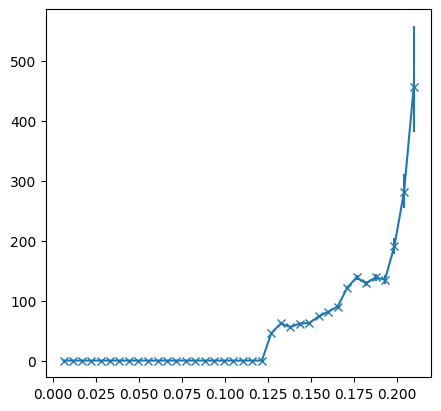

In [35]:
plt.figure(figsize=(12,4), layout='constrained')
plt.subplot(131)
plt.errorbar(kmean, kmse, yerr=kyerr, fmt='-x')

/tmp/ipykernel_1107279/1490988008.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


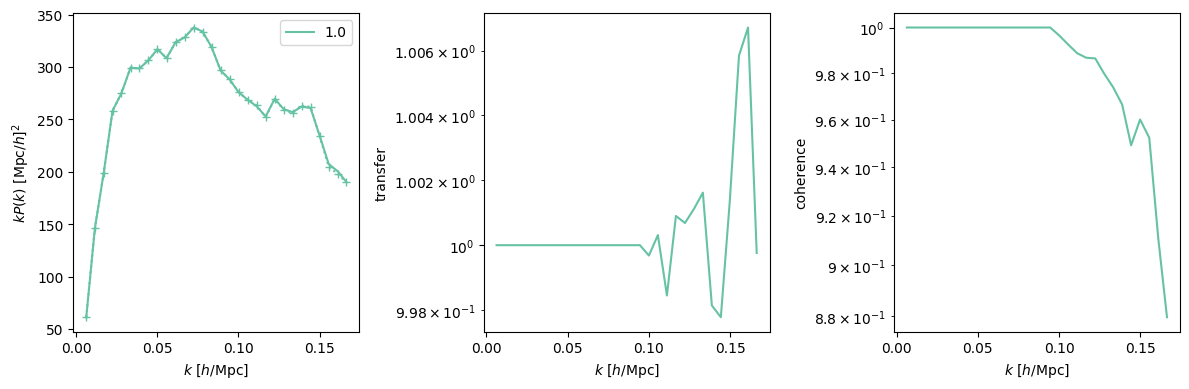

ell max: 322.05497980676125


In [42]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

# labels = ['kaiser', '1lpt', '2lpt', 'pm']
# labels = ['kaiser', '2lpt']
# labels = ['2lpt', '2lpt no noise']
# labels = ['kaiser', 'kaiser_lag', '2lpt']
# labels = 2*['flat sky, no light-cone', 'flat sky, light-cone', 'curved sky, no light-cone', 'curved sky, light-cone']
labels = ['1.0', '1.5', '2.0']
plt.figure(figsize=(12,4), layout='constrained')

for i_plt, (kptc, label) in enumerate(zip(kptcs, labels)):
    # if i_plt% 2:
    #     plot_powtranscoh(*kptc, '-' if i_plt < 4 else '--', label=label)
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
for i_plt, (kpow, label) in enumerate(zip(kpows, labels)):
    plot_pow(*kpow, f'C{i_plt}:+')
# kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
# plot_pow(*kpow_lin, 'k:', label='linear')
# plot_pow(*kpow0, 'k--', label='abacus')
plt.legend()
plt.subplot(1,3,3)
# plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

/tmp/ipykernel_860986/662714855.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


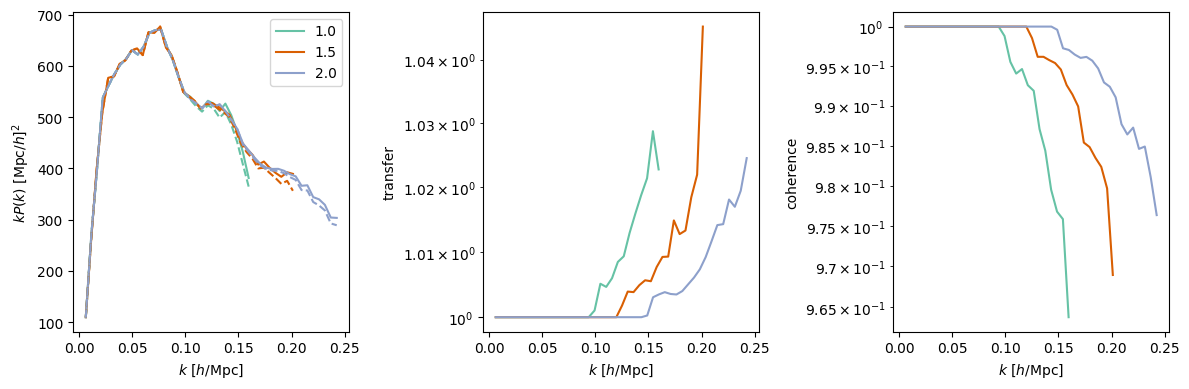

ell max: 308.85450532904366


In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

# labels = ['kaiser', '1lpt', '2lpt', 'pm']
# labels = ['kaiser', '2lpt']
# labels = ['2lpt', '2lpt no noise']
# labels = ['kaiser', 'kaiser_lag', '2lpt']
# labels = 2*['flat sky, no light-cone', 'flat sky, light-cone', 'curved sky, no light-cone', 'curved sky, light-cone']
labels = ['1.0', '1.5', '2.0']
plt.figure(figsize=(12,4), layout='constrained')

for i_plt, (kptc, label) in enumerate(zip(kptcs, labels)):
    # if i_plt% 2:
    #     plot_powtranscoh(*kptc, '-' if i_plt < 4 else '--', label=label)
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
for i_plt, (kpow, label) in enumerate(zip(kpows, labels)):
    plot_pow(*kpow, f'C{i_plt}--')
# kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
# plot_pow(*kpow_lin, 'k:', label='linear')
# plot_pow(*kpow0, 'k--', label='abacus')
plt.legend()
plt.subplot(1,3,3)
# plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

/tmp/ipykernel_801323/3955536792.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


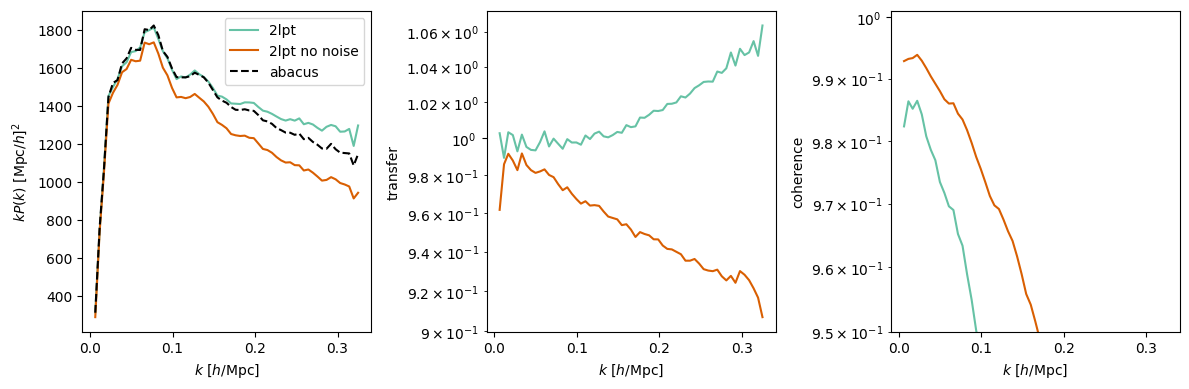

ell max: 629.2208507933007


In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

# labels = ['kaiser', '1lpt', '2lpt', 'pm']
# labels = ['kaiser', '2lpt']
labels = ['2lpt', '2lpt no noise']
plt.figure(figsize=(12,4), layout='constrained')

for kptc, label in zip(kptcs, labels):
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
# kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
# plot_pow(*kpow_lin, 'k:', label='linear')
plot_pow(*kpow0, 'k--', label='abacus')
plt.legend()
plt.subplot(1,3,3)
plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

Text(0, 0.5, '$n$ [$h$/Mpc]$^{3}$')

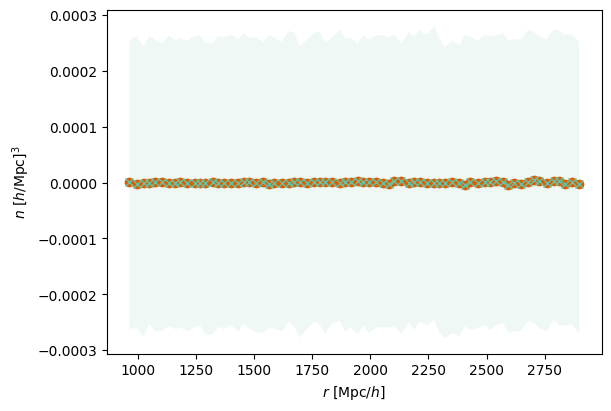

In [ ]:
from montecosmo.bdec import credint
from montecosmo.metrics import mean_errorbar, var_errorbar
from montecosmo.metrics import mse_radius, mse_value, mse_wave, distr_radial

rmesh = model.radius_mesh()
mesh1 = sim['obs']
mesh1 = jr.normal(jr.key(42), model.final_shape)

rcount, rmean, maggr = distr_radial(mesh1, rmesh, model.cell_length, aggr_fn=None)
_, _, mstd = distr_radial(mesh1, rmesh, model.cell_length, aggr_fn=lambda x: jnp.std(x))
rcount, rmean, maggr_sci = distr_radial(mesh1, rmesh, model.cell_length, aggr_fn=partial(credint, p=0.68))

plt.figure(figsize=(6,4), layout='constrained')
yerr = mean_errorbar(rcount, mstd, confidence=0.68)
plt.errorbar(rmean, maggr, yerr=yerr, fmt='x', label='noise')

plt.plot(rmean, maggr, 'o-', label='distr_radial2')
plt.fill_between(rmean, *maggr_sci.T, alpha=0.1)
plt.xlabel("$r$ [Mpc/$h$]")
plt.ylabel("$n$ [$h$/Mpc]$^{3}$")

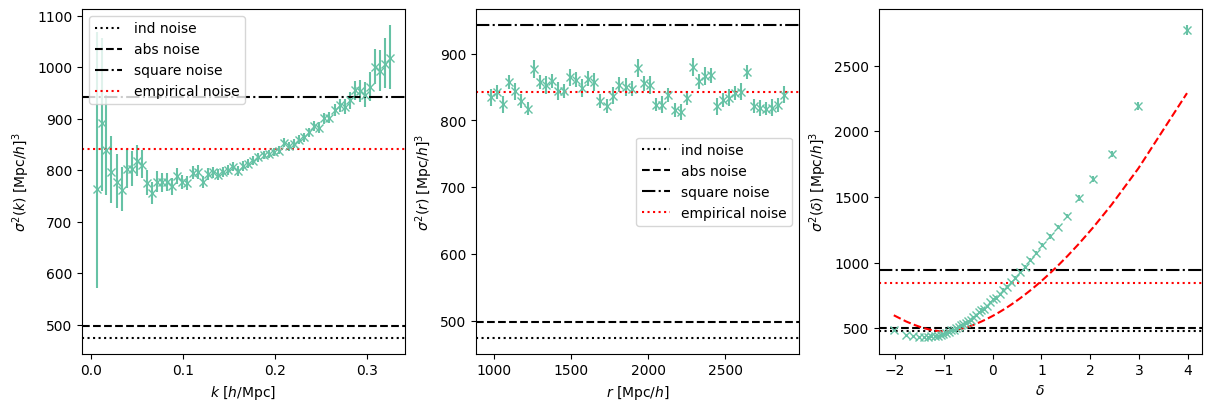

In [ ]:
d1 = delta0
# d1 = delta_sims[0]
d0 = delta_sims[1]
confid = 0.95

kcount, kmean, mse_k = model.mse_wave(d0, d1, include_corners=True)
yerr_k = var_errorbar(kcount, mse_k, confidence=confid)

rcount, rmean, mse_rad = model.mse_radius(d0, d1, redges=50)
yerr_rad = var_errorbar(rcount, mse_rad, confidence=confid)

vcount, vmean, mse_val = model.mse_value(d0, d1, vedges=50, min_count=None)
yerr_val = var_errorbar(vcount, mse_val, confidence=confid)

noise_emp = jnp.var(d0 - d1) * model.cell_length**3
noise_ind = model.loc_fid['s_0'] / model.loc_fid['ngbars']
noise_square = model.loc_fid['s_0'] * (1 + model.loc_fid['s_delta']**2 * jnp.var(d0)) / model.loc_fid['ngbars']
noise_abs = model.loc_fid['s_0'] * jnp.abs(1 + model.loc_fid['s_delta'] * d0).mean() / model.loc_fid['ngbars']
noise_model = lambda x: (model.loc_fid['s_0'] + 0.1 * jnp.abs(1 + x)**1.7) / model.loc_fid['ngbars']

plt.figure(figsize=(12,4), layout='constrained')
plt.subplot(1,3,1)
plt.errorbar(kmean, mse_k, yerr=yerr_k, fmt='x')
plt.axhline(noise_ind, color='k', linestyle=':', label='ind noise') # |1+s*delta|**0
plt.axhline(noise_abs, color='k', linestyle='--', label='abs noise') # |1+s*delta|**1
plt.axhline(noise_square, color='k', linestyle='-.', label='square noise') # |1+s*delta|**2
plt.axhline(noise_emp, color='r', linestyle=':', label='empirical noise')
plt.xlabel("$k$ [$h$/Mpc]")
plt.ylabel("$\\sigma^2(k)$ [Mpc/$h$]$^{3}$")
plt.legend()

plt.subplot(1,3,2)
plt.errorbar(rmean, mse_rad, yerr=yerr_rad, fmt='x')
plt.axhline(noise_ind, color='k', linestyle=':', label='ind noise') # |1+s*delta|**0
plt.axhline(noise_abs, color='k', linestyle='--', label='abs noise') # |1+s*delta|**1
plt.axhline(noise_square, color='k', linestyle='-.', label='square noise') # |1+s*delta|**2
plt.axhline(noise_emp, color='r', linestyle=':', label='empirical noise')
plt.xlabel("$r$ [Mpc/$h$]")
plt.ylabel("$\\sigma^2(r)$ [Mpc/$h$]$^{3}$")
plt.legend()

plt.subplot(1,3,3)
plt.errorbar(vmean, mse_val, yerr=yerr_val, fmt='x')
plt.axhline(noise_ind, color='k', linestyle=':', label='ind noise') # |1+s*delta|**0
plt.axhline(noise_abs, color='k', linestyle='--', label='abs noise') # |1+s*delta|**1
plt.axhline(noise_square, color='k', linestyle='-.', label='square noise') # |1+s*delta|**2
plt.axhline(noise_emp, color='r', linestyle=':', label='empirical noise')
plt.plot(vmean, noise_model(vmean), 'r--', label='noise model')

plt.xlabel("$\\delta$")
plt.ylabel("$\\sigma^2(\\delta)$ [Mpc/$h$]$^{3}$")
plt.show()


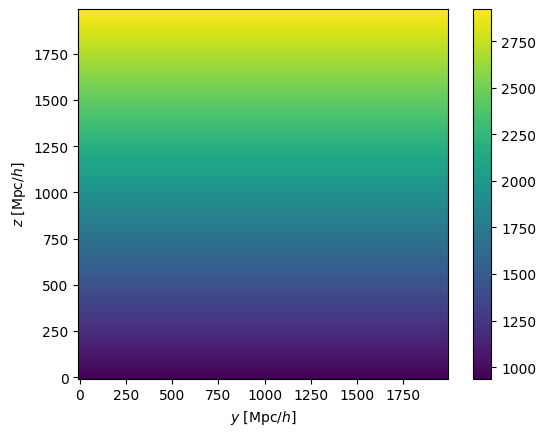

In [ ]:
plot_mesh(model.radius_mesh(), model.box_size, axis=0)
plt.colorbar()

/tmp/ipykernel_1865514/993061259.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


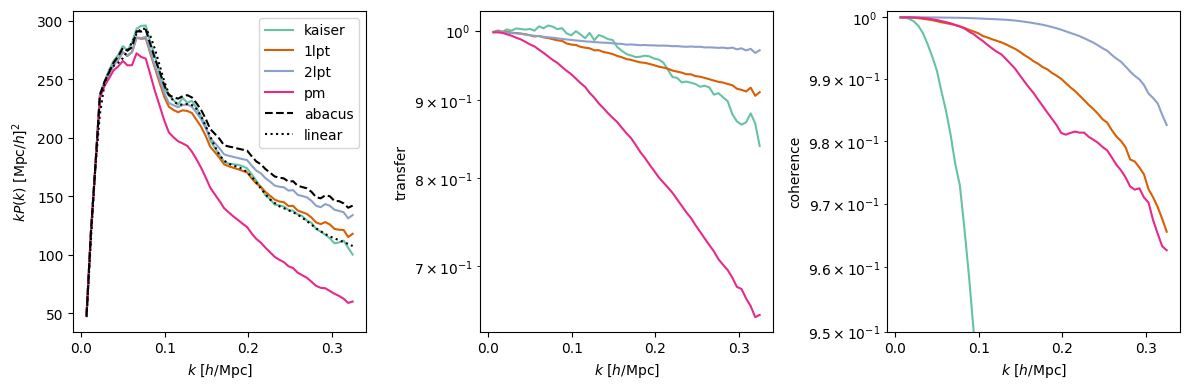

ell max: 629.2208507933007


In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_pow, plot_mesh, theme
from montecosmo.bricks import lin_power_interp
from montecosmo.nbody import a2chi
theme()

labels = ['kaiser', '1lpt', '2lpt', 'pm']
plt.figure(figsize=(12,4), layout='constrained')

for kptc, label in zip(kptcs, labels):
    plot_powtranscoh(*kptc, label=label)

plt.subplot(1,3,1)
kpow_lin = kpow0[0], lin_power_interp(model.cosmo_fid, a=1/(1+z_obs))(kpow0[0])
plot_pow(*kpow0, 'k--', label='abacus')
plot_pow(*kpow_lin, 'k:', label='linear')
plt.legend()
plt.subplot(1,3,3)
plt.ylim(0.95,1.001)
plt.tight_layout()
plt.show()

ell_max = kpow0[0][-1] * a2chi(model.cosmo_fid, a=1/(1+z_obs)) - 0.5
print("ell max:", ell_max)

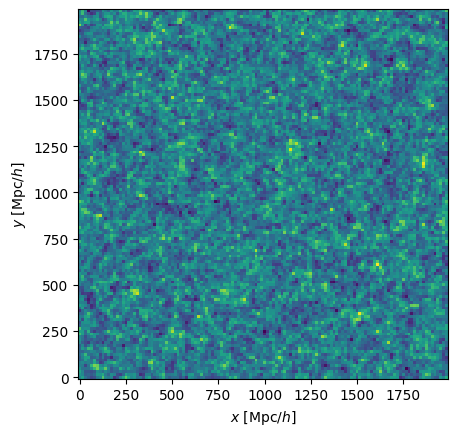

In [ ]:
plot_mesh(sim['obs'], model.box_size)